In this notebook, I created and trained the autoencoder in the frequency domain

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')
%cd gdrive/'My Drive'/Internship/Project

Mounted at /content/gdrive/
/content/gdrive/My Drive/Internship/Project


In [ ]:
%run Code/Final/DataPreparation.ipynb

In [ ]:
%run Code/Final/Performance_metrics.ipynb

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
from sklearn.preprocessing import RobustScaler
from pickle import dump, load
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tqdm.notebook import trange, tqdm
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LeakyReLU, ReLU, Activation, Dropout, PReLU, \
                                    BatchNormalization, Flatten, Dense, Reshape, Input, AveragePooling1D, UpSampling1D

from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [ ]:
# load training data
file_signal = h5py.File('Data/train_folder.h5', 'r')
data = file_signal['data'][()]
bad_quality = file_signal['bad_quality'][()]
recording_endings = file_signal['recording_endings'][()]
file_signal.close()

In [ ]:
# separate normal from anomalous data
d_clean = np.delete(data, bad_quality, axis=0)
d_dirty = data[bad_quality]

In [ ]:
# Get the spectrogram data
fourier_clean = fourier_lowmem(d_clean, 20)
fourier_dirty = fourier_lowmem(d_dirty)

In [ ]:
# shuffle data and separate the to training and validation set
fourier_clean = shuffle(fourier_clean)
X_train = fourier_clean[:int(fourier_clean.shape[0]*0.7)]
X_test = fourier_clean[int(fourier_clean.shape[0]*0.7):]

In [ ]:
class ConvAutoencoder:
  '''
  Based on https://www.pyimagesearch.com/2020/02/24/denoising-autoencoders-with-keras-tensorflow-and-deep-learning/
  kernel: The size of the convolutional kernels, chosen to be the same for simplicity
  filters: Number of filters/units the encoder and decoder will learn, respectively
  snippet_len: Length of the input signal (default 500/4=125).
  latentDim: Dimensionality of the latent-space representation.
  channels: the number of channels in the signal
  dropout: the dropout rate to be added in the convolutional layers
  '''

  @staticmethod
  def build(kernel, filters, latentDim, dil=1, snippet_len=125,  channels=4, dropout=0.3): 

    # initialize the input shape to be "channels last" along with the channels dimension itself
    inputShape = (snippet_len, channels)

    # define the input to the encoder
    inputs = Input(shape=inputShape)

    x = inputs
    # loop over the number of filters
    for f in filters:
      x = Conv1D(f, kernel, padding="same", dilation_rate=dil,
                #  kernel_regularizer='l1', bias_regularizer='l1',
                 )(x)
      x = PReLU()(x)

      if dropout != 0:
        x = Dropout(dropout)(x)

    # flatten the network and then construct our latent vector
    volumeSize = K.int_shape(x)

    x = Flatten()(x)
    latent = Dense(latentDim)(x)

    # build the encoder model
    encoder = Model(inputs, latent, name="encoder")

    # start building the decoder model which will accept the output of the encoder as its inputs
    latentInputs = Input(shape=(latentDim))
    x = Dense(np.prod(volumeSize[1:]))(latentInputs)
    x = Reshape((volumeSize[1], volumeSize[2]))(x)

    # loop over our number of filters again, but this time in reverse order
    for f in filters[::-1]:
      x = Conv1DTranspose(f, kernel, padding="same", dilation_rate=dil, 
                          # kernel_regularizer='l1', bias_regularizer='l1',
                          )(x)
      x = PReLU()(x)

      if dropout != 0:
        x = Dropout(dropout)(x)

    # apply a single CONV_TRANSPOSE layer used to recover the original depth of the signal
    x = Conv1DTranspose(channels, kernel, padding="same", dilation_rate=dil)(x)
    outputs = x
    
    # build the decoder model
    decoder = Model(latentInputs, outputs, name="decoder")

    # our autoencoder is the encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

    # return a 3-tuple of the encoder, decoder, and autoencoder
    return (encoder, decoder, autoencoder)

In [ ]:
# define checkpoints
checkpoint_train = ModelCheckpoint('checkpoint_fourier_train.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
checkpoint_val = ModelCheckpoint('checkpoint_fourier_val.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint_train, checkpoint_val]

In [ ]:
# intialize the autoencoder
(encoder, decoder, autoencoder) = ConvAutoencoder.build(kernel=5, filters=(60, 30), latentDim=30, snippet_len=125//2, channels=4)
INIT_LR = 1e-4
EPOCHS = 150
b_size = 32

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss=tf.keras.losses.mae, optimizer=opt)      

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62, 4)]           0         
_________________________________________________________________
encoder (Functional)         (None, 30)                71700     
_________________________________________________________________
decoder (Functional)         (None, 62, 4)             78034     
Total params: 149,734
Trainable params: 149,734
Non-trainable params: 0
_________________________________________________________________


In [ ]:
H = autoencoder.fit(x=X_train, y=X_train, batch_size=b_size, epochs=EPOCHS, 
                    validation_data=(X_test, X_test), callbacks=callbacks_list, verbose=2) 

Epoch 1/150

Epoch 00001: loss improved from inf to 0.02266, saving model to checkpoint_fourier_train.h5

Epoch 00001: val_loss improved from inf to 0.01922, saving model to checkpoint_fourier_val.h5
15696/15696 - 124s - loss: 0.0227 - val_loss: 0.0192
Epoch 2/150

Epoch 00002: loss did not improve from 0.02266

Epoch 00002: val_loss improved from 0.01922 to 0.01893, saving model to checkpoint_fourier_val.h5
15696/15696 - 123s - loss: 0.0228 - val_loss: 0.0189
Epoch 3/150

Epoch 00003: loss improved from 0.02266 to 0.02108, saving model to checkpoint_fourier_train.h5

Epoch 00003: val_loss improved from 0.01893 to 0.01855, saving model to checkpoint_fourier_val.h5
15696/15696 - 123s - loss: 0.0211 - val_loss: 0.0185
Epoch 4/150

Epoch 00004: loss did not improve from 0.02108

Epoch 00004: val_loss did not improve from 0.01855
15696/15696 - 123s - loss: 0.0213 - val_loss: 0.0200
Epoch 5/150

Epoch 00005: loss improved from 0.02108 to 0.02073, saving model to checkpoint_fourier_train.h5


KeyboardInterrupt: ignored

In [ ]:
fourier_clean = shuffle(fourier_clean)
fourier_dirty = shuffle(fourier_dirty)
fourier_clean = fourier_clean[:50000]
fourier_dirty = fourier_dirty[:50000]

In [ ]:
clean_errors = find_errors(fourier_clean, autoencoder)
anom_errors = find_errors(fourier_dirty, autoencoder)

In [ ]:
print('mean clean error = %.4f, std clean error = %.4f\nmean anom error = %.4f, std anom error = %.4f'
                              % (np.mean(clean_errors), np.std(clean_errors), np.mean(anom_errors), np.std(anom_errors))                              )

mean clean error = 0.0073, std clean error = 0.1148
mean anom error = 0.0038, std anom error = 0.0200


In [ ]:
original = fourier_dirty
reconstructed = autoencoder.predict(original)

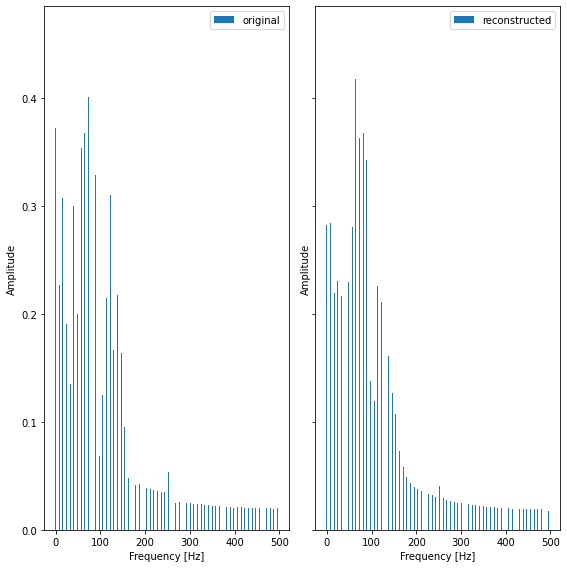

In [ ]:
# Plot the spectrograms
N = 125


f = np.fft.fftfreq(N, 1/500)[:N//2] # 500 Hz sampling rate

id = 10 # pick a segment
channel = 0

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8,8))
ax1.bar(f, original[id,:,channel], width=2, label='original')
ax1.legend()
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Frequency [Hz]")
ax2.bar(f, np.abs(reconstructed[id,:,channel]), width=2, label='reconstructed')
ax2.legend()
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

In [ ]:
original_d = fourier_clean
reconstructed_d = autoencoder.predict(original_d)

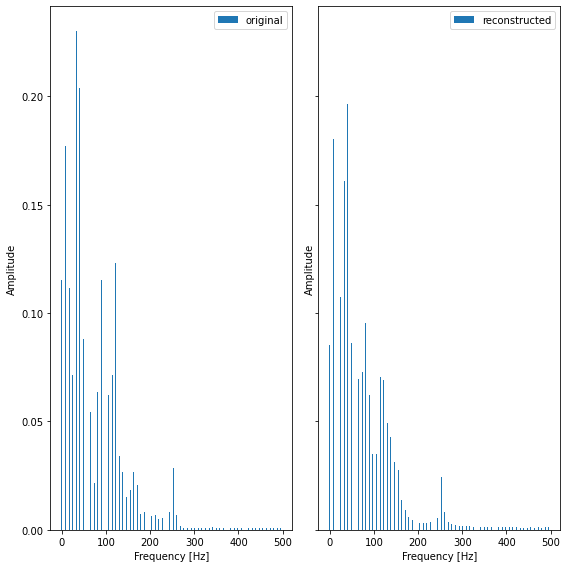

In [ ]:
# Plot the spectrograms
N = 125


f = np.fft.fftfreq(N, 1/500)[:N//2] # 500 Hz sampling rate

id = 10 # pick a segment
channel = 0

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8,8))
ax1.bar(f, original_d[id,:,channel], width=2, label='original')
ax1.legend()
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Frequency [Hz]")
ax2.bar(f, np.abs(reconstructed_d[id,:,channel]), width=2, label='reconstructed')
ax2.legend()
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()